In [1]:
from lenspyx.lensing import get_geom
from lenspyx.remapping.deflection_029 import deflection
from lenspyx.remapping import utils_geom

from lenscarf.utils_hp import alm_copy, almxfl, gauss_beam, alm2cl, synalm, default_rng, Alm
from lenscarf.utils import cli

from lenscarf import utils_sims

import matplotlib.pyplot as plt

import numpy as np

import os 
from os.path import join as opj

from plancklens import utils

import healpy as hp


In [2]:
def _get_gtmap(self, tlm_wf:np.ndarray, q_pbgeom:utils_geom.pbdGeometry):
    """Wiener-filtered gradient leg to feed into the QE


        :math:`\sum_{lm} (-Tlm) sqrt(l (l+1)) _1 Ylm(n)


    """
    assert  Alm.getlmax(tlm_wf.size, self.mmax_sol)== self.lmax_sol, (Alm.getlmax(tlm_wf.size, self.mmax_sol), self.lmax_sol)
    fl = -np.sqrt(np.arange(self.lmax_sol + 1) * np.arange(1, self.lmax_sol + 2))
    ffi = self.ffi.change_geom(q_pbgeom) if q_pbgeom is not self.ffi.pbgeom else self.ffi
    return ffi.gclm2lenmap([almxfl(tlm_wf, fl, self.mmax_sol, False), np.zeros_like(tlm_wf)], self.mmax_sol, 1, False)

In [3]:
def _get_irestmap(self, tlm_dat:np.ndarray, tlm_wf:np.ndarray, q_pbgeom:utils_geom.pbdGeometry):
        """Builds inverse variance weighted map to feed into the QE


            :math:`B^t N^{-1}(X^{\rm dat} - B D X^{WF})`


        """
        twf = tlm_dat - self.ffi.lensgclm(tlm_wf, self.mmax_sol, 0, self.lmax_len, self.mmax_len).squeeze() #almxfl(self.ffi.lensgclm(tlm_wf, self.mmax_sol, 0, self.lmax_len, self.mmax_len).squeeze(), np.ones_, self.mmax_len, False)
        almxfl(twf, self.inoise_1, self.mmax_len, True)
        return q_pbgeom.geom.alm2map(twf, self.lmax_len, self.mmax_len, self.ffi.sht_tr, (-1., 1.))

In [4]:
def _get_irestmap_alt(self, twf_len:np.ndarray, twf:np.ndarray, q_pbgeom:utils_geom.pbdGeometry, ftl):
    #twf_len = self.geom_.map2alm(tdat, self.lmax_len, self.mmax_len, self.ffi.sht_tr)
    twf_len = almxfl(twf_len, ftl, self.mmax_len, False)
    return q_pbgeom.geom.alm2map(twf_len, self.lmax_len, self.mmax_len, self.ffi.sht_tr, (-1., 1.))

In [5]:
class Obj(object):
    def __init__(self, mmax_sol, lmax_sol, ffi, lmax_len, mmax_len, inoise_1):
        self.lmax_sol = lmax_sol
        self.mmax_sol = mmax_sol
        self.ffi = ffi
        self.lmax_len = lmax_len
        self.mmax_len = mmax_len
        self.inoise_1 = inoise_1

In [6]:
cls_path = opj(os.environ['HOME'], 'fgcmblensing', 'input', 'websky')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls_websky.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls_websky.dat'))
#cls_grad = camb_clfile_gradient(opj(cls_path, 'new_lensedCMB_dmn1_lensedgradCls_websky.dat'))

In [7]:
lmax_ivf, mmax_ivf, beam, nlev_t, nlev_p = (4000, 4000, 1., 1., 1. * np.sqrt(2.))

nlev_t_filter = nlev_t

lmin_tlm, lmin_elm, lmin_blm = (10, 10, 10) # The fiducial transfer functions are set to zero below these lmins
# for delensing useful to cut much more B. It can also help since the cg inversion does not have to reconstruct those.

lmax_phi, mmax_phi = (4500, 4500)
lmax_qlm, mmax_qlm = (lmax_phi, mmax_phi) # Lensing map is reconstructed down to this lmax and mmax
# NB: the QEs from plancklens does not support mmax != lmax, but the MAP pipeline does
lmax_unl, mmax_unl = (4500, 4500) # Delensed CMB is reconstructed down to this lmax and mmax

In [8]:
transf_tlm   =  gauss_beam(beam/180 / 60 * np.pi, lmax=1.5*lmax_ivf) * (np.arange(1.5*lmax_ivf + 1) >= lmin_tlm)
ftl =  cli(cls_len['tt'][:int(1.5*lmax_ivf + 1)] + (nlev_t_filter / 180 / 60 * np.pi) ** 2 * cli(transf_tlm ** 2)) * (transf_tlm > 0)

In [9]:
inoise_1 = transf_tlm**2 * nlev_t**(-2) * (180 * 60 / np.pi) ** 2

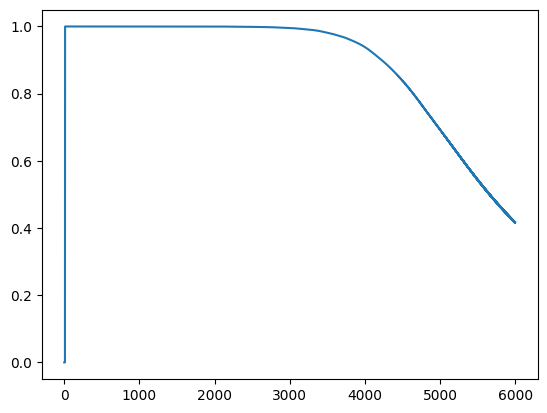

In [10]:
lmaxftl = len(ftl)
plt.plot(ftl*cls_len['tt'][:lmaxftl])

In [11]:
nside = 2048
geominfo = ('healpix', {'nside': nside}) 
geom = get_geom(geominfo)

In [12]:
path = "/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/lenscarfrecs/ptt_bh_s_sim0000bh/"


pfile = "phi_plm_it000.npy"

inputphi = "/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/plm_in_0_lmax5120.fits"

tlm = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/sim_0000_tlm.fits")

plm = hp.read_alm(inputphi)

plm0 = np.load(opj(path, pfile))

In [13]:
tmapor = hp.alm2map(tlm, nside)
tlmsor = hp.map2alm(tmapor, lmax = lmax_unl, iter = 0)

In [14]:
tmap = geom.alm2map(tlmsor, lmax_unl, mmax_unl, 0, (-1., 1.))
tlms = geom.map2alm(tmap, lmax_unl, mmax_unl, 0, (-1., 1.))

In [31]:
ffi = deflection(geom, plm0, mmax_qlm, numthreads = 0, verbosity=0, epsilon = 1e-7)

In [32]:
delensedlm = ffi.lensgclm(tlms.copy(), mmax_unl, 0, lmax_ivf, mmax_ivf, backwards = True)

In [33]:
filtereddelensedlm = almxfl(delensedlm, ftl, mmax_ivf, False)

In [34]:
ufiltereddelensedlm = almxfl(filtereddelensedlm, cls_unl["tt"], mmax_ivf, False)

In [35]:
tlmsfiltered = almxfl(tlms, ftl, mmax_unl, False)
delensedlmfiltered = ffi.lensgclm(tlmsfiltered, mmax_unl, 0, lmax_ivf, mmax_ivf, backwards = True)

In [36]:
udelensedlmfiltered = almxfl(delensedlmfiltered, cls_unl["tt"], mmax_ivf, False)

In [37]:
utlmsfiltered = almxfl(tlmsfiltered, cls_unl["tt"], mmax_unl, False)

In [38]:
delcls = hp.alm2cl(delensedlm)
cls = hp.alm2cl(tlms)
clsor = hp.alm2cl(tlm)

delclsfiltered = hp.alm2cl(delensedlmfiltered)
filtereddelcls = hp.alm2cl(filtereddelensedlm)
#crosscls = hp.alm2cl(tlms, delensedlm)

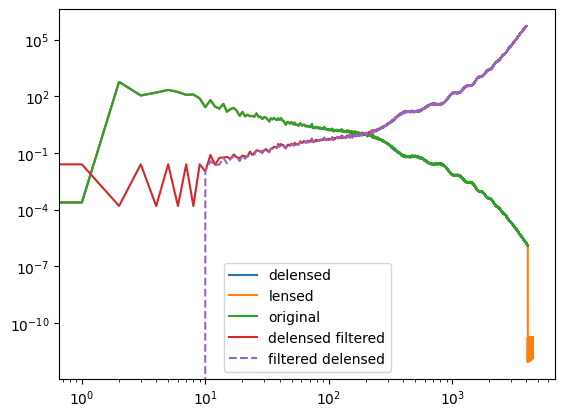

In [39]:
plt.loglog(delcls, label = "delensed")
plt.loglog(cls, label = "lensed")
plt.loglog(clsor, label = "original")

plt.loglog(delclsfiltered, label = "delensed filtered")
plt.loglog(filtereddelcls, label = "filtered delensed", ls = '--')

#plt.loglog(crosscls, label = "cross")
plt.legend()

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_45038/233515356.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(delclsfiltered/filtereddelcls, label =  "filtering")


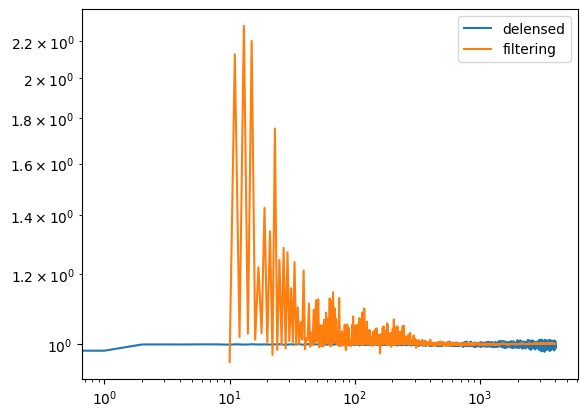

In [40]:
#plot fraction between delensed and lensed

plt.loglog(delcls/cls[0:delcls.size], label = "delensed")

plt.loglog(delclsfiltered/filtereddelcls, label =  "filtering")

plt.legend()


In [41]:
O = Obj(mmax_sol=lmax_ivf, lmax_sol=mmax_ivf, ffi=ffi, lmax_len=lmax_unl, mmax_len=mmax_unl, inoise_1=inoise_1)

In [42]:
def get_QE(A, B, alt = False):
    gmap = _get_gtmap(O, A, ffi.pbgeom)
    imap = _get_irestmap(O, B, A, ffi.pbgeom) if alt else _get_irestmap_alt(O, B, 0, ffi.pbgeom, ftl)
    d1 = gmap*imap
    G, C = ffi.geom.map2alm_spin(d1, 1, ffi.lmax_dlm, ffi.mmax_dlm, 0, (-1., 1.))
    fl = - np.sqrt(np.arange(O.ffi.lmax_dlm + 1, dtype=float) * np.arange(1, O.ffi.lmax_dlm + 2))
    almxfl(G, fl, O.ffi.mmax_dlm, True)
    return G

In [44]:
G = get_QE(udelensedlmfiltered, tlms, True)

In [45]:
Glensed = ffi.lensgclm(G, mmax_unl, 0, lmax_unl, mmax_unl).squeeze()

In [46]:
tlmsor = hp.map2alm(tmapor, lmax = lmax_ivf, iter = 0)
tlmsQE = geom.map2alm(geom.alm2map(tlmsor, lmax_ivf, lmax_ivf, 0, (-1., 1.)), lmax_ivf, mmax_ivf, 0, (-1., 1.))

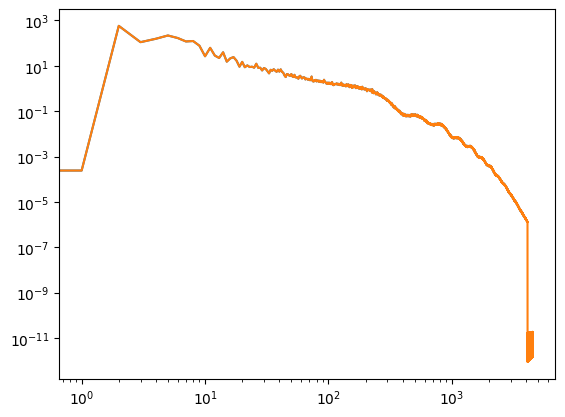

In [47]:
plt.loglog(hp.alm2cl(tlmsQE))
plt.loglog(hp.alm2cl(tlms))

In [48]:
G2 = get_QE(alm_copy(utlmsfiltered, mmax_unl, lmax_ivf, mmax_ivf), tlms)

In [49]:
plmc = alm_copy(plm, hp.Alm.getlmax(plm.size), O.ffi.lmax_dlm, O.ffi.lmax_dlm)

In [50]:
inin = hp.alm2cl(plmc)

In [51]:
plmc.shape

(10131751,)

In [52]:
clG = hp.alm2cl(G, plmc)
clG2 = hp.alm2cl(G2, plmc)
clGlensed = hp.alm2cl(Glensed, plmc)

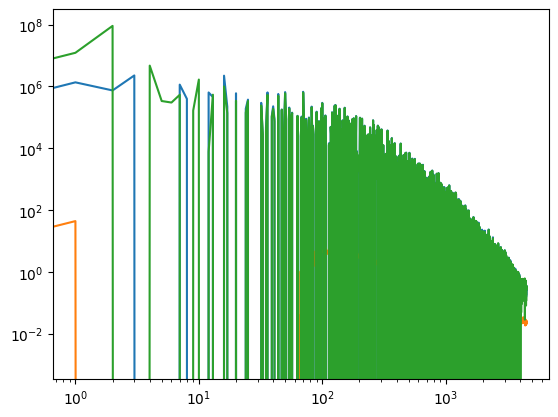

In [53]:
plt.loglog(clG)
plt.loglog(clG2)
#plt.ylim(1e-10, 1)
plt.loglog(clGlensed)